In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

print('Modules loaded!')

Modules loaded!


In [4]:
pip install opencv-python


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)
Note: you may need to restart the kernel to use updated packages.


In [6]:
dataset_path = r"C:\Users\shash\Desktop\Execution_oral\train"
val_path = r"C:\Users\shash\Desktop\Execution_oral\val"
test_path = r"C:\Users\shash\Desktop\Execution_oral\test"
categories = ['Normal', 'OSCC']

# Use ImageDataGenerator instead of manual DataFrame creation for efficiency
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generators
batch_size = 32
img_size = (224, 224)  # MobileNetV2 default size

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',  # Binary classification
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    test_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

print("Data Generators Created!")
class_labels = ['Normal', 'OSCC']

Found 4946 images belonging to 2 classes.
Found 120 images belonging to 3 classes.
Found 126 images belonging to 2 classes.
Data Generators Created!


In [7]:
# Load MobileNetV2 with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze early layers, unfreeze later ones
for layer in base_model.layers[:100]:  # Freeze first 100 layers (out of ~155)
    layer.trainable = False
for layer in base_model.layers[100:]:  # Fine-tune remaining layers
    layer.trainable = True

# Add custom head
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=True)  # Ensure BatchNormalization works correctly
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

# Create model
model = Model(inputs, outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,587,201 (9.87 MB)

 Trainable params: 2,190,145 (8.35 MB)

 Non-trainable params: 397,056 (1.51 MB)

In [8]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)

C:\Users\DELL\anaconda33\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 437s 3s/step - accuracy: 0.6494 - loss: 4.9073 - precision: 0.6650 - recall: 0.6277 - val_accuracy: 0.1417 - val_loss: 1.0081 - val_precision: 1.0000 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 451s 3s/step - accuracy: 0.8359 - loss: 4.0797 - precision: 0.8536 - recall: 0.8225 - val_accuracy: 0.1250 - val_loss: -1.1674 - val_precision: 1.0000 - val_recall: 0.8583 - learning_rate: 1.0000e-04
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 454s 3s/step - accuracy: 0.8920 - loss: 3.5526 - precision: 0.9092 - recall: 0.8756 - val_accuracy: 0.1333 - val_loss: -3.6211 - val_precision: 1.0000 - val_recall: 0.8917 - learning_rate: 1.0000e-04
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 446s 3s/step - accuracy: 0.9069 - loss: 3.1376 - precision: 0.9109 - recall: 0.9048 - val_accuracy: 0.1333 - val_loss: -4.1792 - val_precision: 1.0000 - val_recall: 0.9000 - learning_rate: 1.0000e-04
Epoch 5/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 4

4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8066 - loss: 3.2598 - precision: 0.6758 - recall: 0.9958
Test Accuracy: 0.8889, Precision: 0.8785, Recall: 0.9895
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step


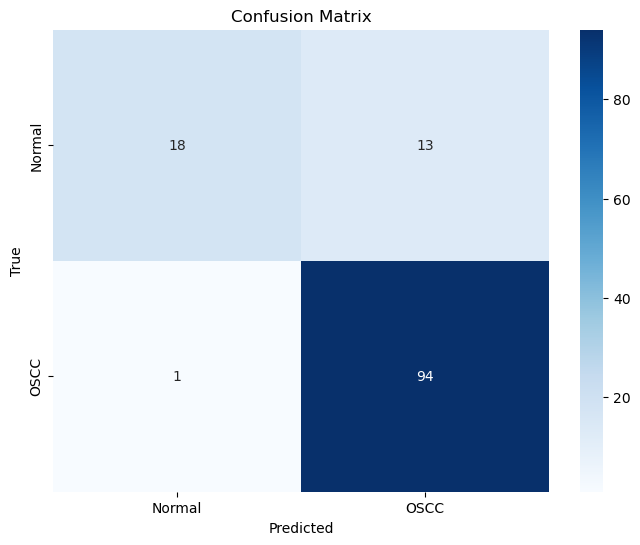

              precision    recall  f1-score   support

      Normal       0.95      0.58      0.72        31
        OSCC       0.88      0.99      0.93        95

    accuracy                           0.89       126
   macro avg       0.91      0.79      0.83       126
weighted avg       0.90      0.89      0.88       126



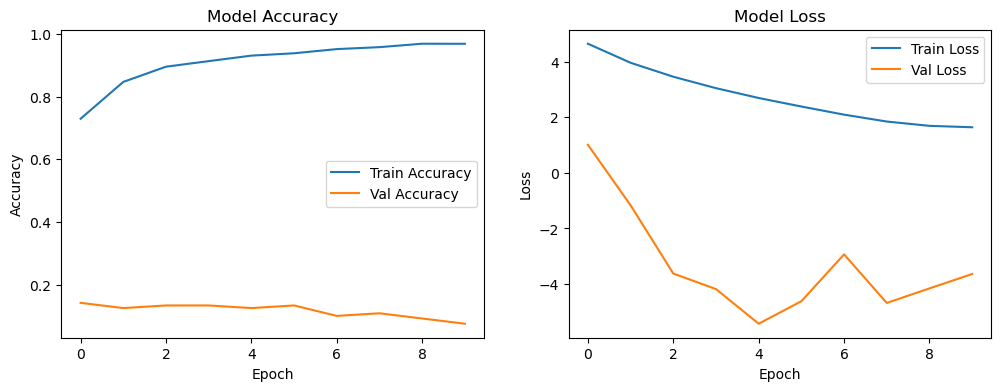

In [9]:
# Evaluate on test set
test_loss, test_acc, test_prec, test_rec = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Precision: {test_prec:.4f}, Recall: {test_rec:.4f}")

# Predictions and Confusion Matrix
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()  # Binary threshold
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Plot Training History
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted Class: OSCC
Confidence: 30.66%


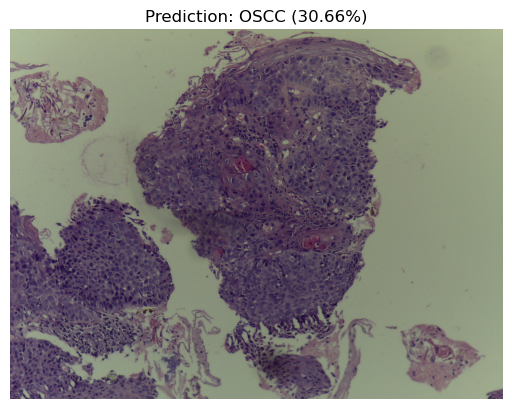

In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Define a MobileNetV2 model for binary classification
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

def predict_and_display(image_path, model, class_labels):
    # Load and preprocess image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    img_array = np.expand_dims(img, axis=0)
    img_array = preprocess_input(img_array)  # MobileNetV2 preprocessing

    # Predict
    prediction = model.predict(img_array)  # Shape: (1, 1)
    pred_class = int(prediction[0][0] > 0.5)  # Access the single probability
    confidence = prediction[0][0] * 100 if pred_class == 0 else (1 - prediction[0][0]) * 100

    # Display result
    print(f"Predicted Class: {class_labels[pred_class]}")
    print(f"Confidence: {confidence:.2f}%")

    # Visualize
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Prediction: {class_labels[pred_class]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# Define class labels for binary classification
class_labels = ['Normal', 'OSCC']

# Test the prediction
image_path_to_test = r"val\OSCC\OSCC_100x_308.jpg"
predict_and_display(image_path_to_test, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Predicted Class: Normal
Confidence: 41.01%


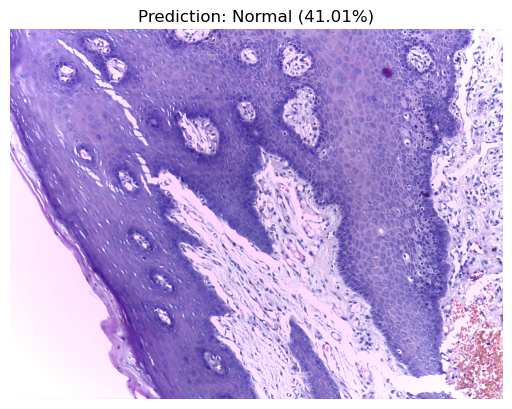

In [39]:
image_path_to_test = r"test\Normal\Normal_100x_2.jpg"
predict_and_display(image_path_to_test, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Predicted Class: OSCC
Confidence: 40.97%


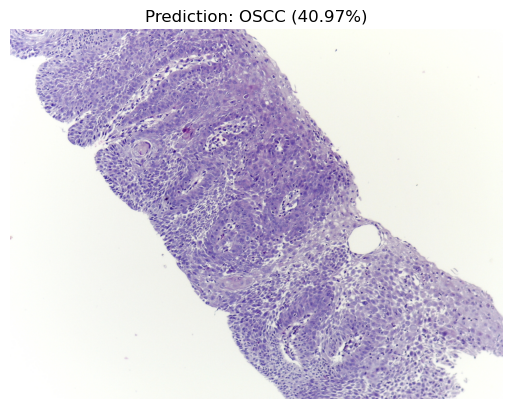

In [40]:
image_path_to_test = r"test\OSCC\OSCC_100x_2.jpg"
predict_and_display(image_path_to_test, model, class_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Class: Normal
Confidence: 44.01%


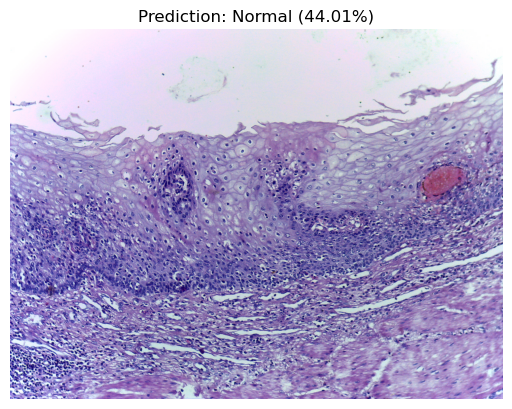

In [47]:
image_path_to_test = r"test\Normal\Normal_100x_83.jpg"
predict_and_display(image_path_to_test, model, class_labels)